In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from Scaling import MinMaxScaling
from Scaling import UnitNormalScaling
from knn import KNN

In [39]:
path = 'spotify.csv'
df = pd.read_csv(path)

In [40]:
genreIndex = df['track_genre'].unique()
genreIndex = {f:i for i,f in enumerate(genreIndex,0)}
df['genre_index'] = df['track_genre'].map(genreIndex)

In [41]:
print("The number of unique songs is",len(df['track_id'].unique()),"\nAnd the number of entries/rows in the dataframe is",df.shape[0])

The number of unique songs is 89741 
And the number of entries/rows in the dataframe is 114000


As we can see the number of rows is not equal to the number of unique songs, we can conclude that songs are repeating, i.e., some songs have multiple genres. This means that some songs have multiple genres and as mentioned in the Tutorial we have to remove all those songs and only keep one occurance of it.

Let's do it

In [42]:
df = df.drop_duplicates(subset='track_id', keep='first')

In [43]:
# Reference stackoverflow.com
df = df.sample(frac=1,random_state=42)

Dividing the data into train, validate and test data in the ration 80:10:10

In [44]:
print(df.shape)
trainLen = (int)(0.8*(df.shape[0]))
testLen = valLen = (int)((df.shape[0]-trainLen)/2)

df_train = df[:trainLen][:]
df_val = df[trainLen:trainLen+valLen][:]
df_test =  df[trainLen+testLen:][:]
print(df_train.shape)
print(df_test.shape)
print(df_train.shape[0] + df_test.shape[0] + df_val.shape[0] == df.shape[0])
# df_test

(89741, 22)
(71792, 22)
(8975, 22)
True


Storing the train dataset into the interim folder

In [45]:
df_train.to_csv('spotify_train.csv',index=False)
df_val.to_csv('spotify_val.csv',index=False)
df_test.to_csv('spotify_test.csv',index=False)

Loading the train dataset

In [46]:
df_train = pd.read_csv('spotify_train.csv')

Note that now df referes to our training dataset

In [47]:
print(df_train.dtypes)

Unnamed: 0            int64
track_id             object
artists              object
album_name           object
track_name           object
popularity            int64
duration_ms           int64
explicit               bool
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
track_genre          object
genre_index           int64
dtype: object


In [48]:
print(df_train.shape)

(71792, 22)


Naming the Unnamed column as index

In [49]:
df_train.rename(columns = {'Unnamed: 0': 'index'},inplace=True)
# Reference : www.begincodingnow.com

In [50]:
print(df_train.dtypes)

index                 int64
track_id             object
artists              object
album_name           object
track_name           object
popularity            int64
duration_ms           int64
explicit               bool
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
track_genre          object
genre_index           int64
dtype: object


Checking for missing values

In [51]:
missing={x:df_train[x].isnull().sum() for x in df_train.columns}
for i in missing.keys():
    print(i,missing[i],'\n')
print('Total missing values are ',sum(missing.values()))

index 0 

track_id 0 

artists 0 

album_name 0 

track_name 0 

popularity 0 

duration_ms 0 

explicit 0 

danceability 0 

energy 0 

key 0 

loudness 0 

mode 0 

speechiness 0 

acousticness 0 

instrumentalness 0 

liveness 0 

valence 0 

tempo 0 

time_signature 0 

track_genre 0 

genre_index 0 

Total missing values are  0


Dropping rows with at least one null value

In [52]:
df_train = df_train.dropna()

In [53]:
print(df_train.shape)

(71792, 22)


Converting out target variable, i.e., track_genre, from categorical to numeric variable by assigning it to an index

In [54]:
numericCols = [feature for feature in df_train.columns if df_train[feature].dtype != 'O'] # Int and float both
columnsNan = [feature for feature in df_train.columns if df_train[feature].isnull().sum() > 0]
discreteCols = [feature for feature in numericCols if len(df_train[feature].unique()) < 25]
continuousCols = [feature for feature in numericCols if feature not in discreteCols]
floatCols = [feature for feature in df_train.columns if df_train[feature].dtypes == 'float64']

Plotting the Histogram and box plots of each feature to check for outliers and skewness of the distribution of that particular feature

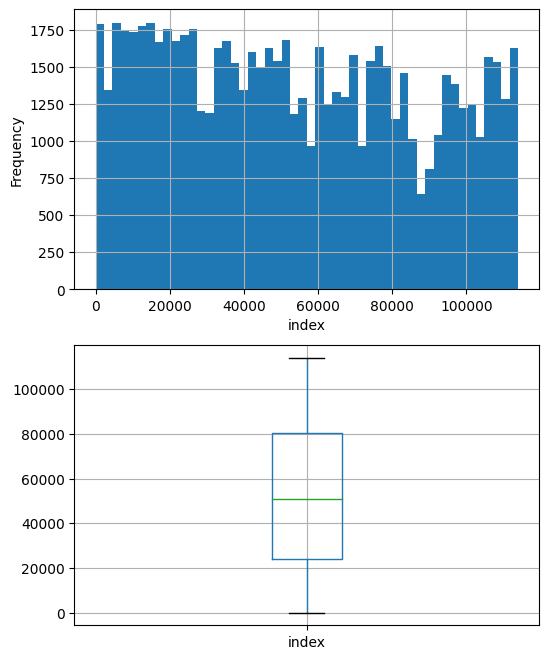

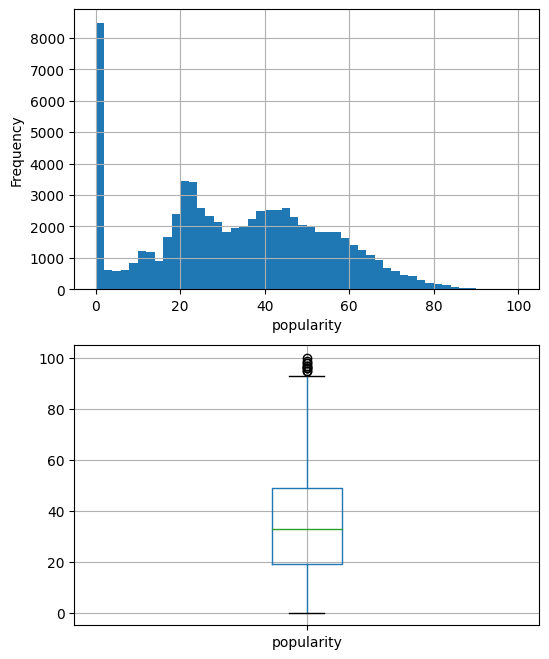

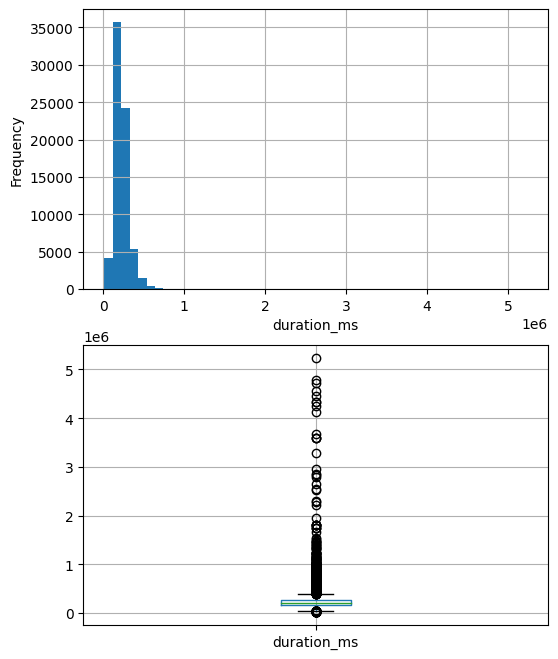

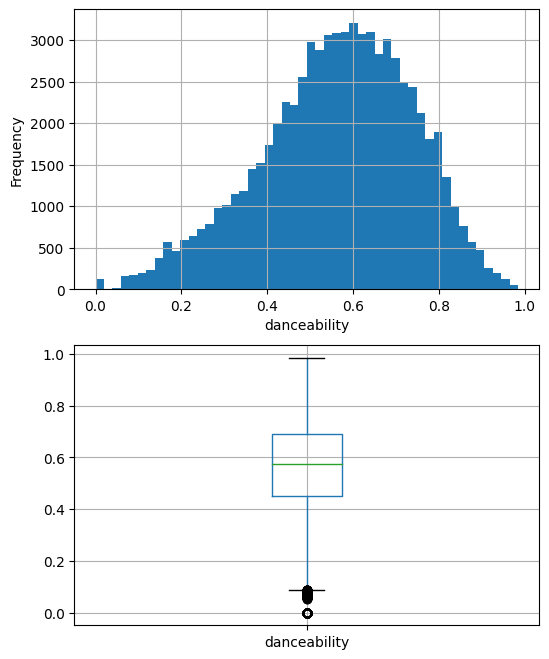

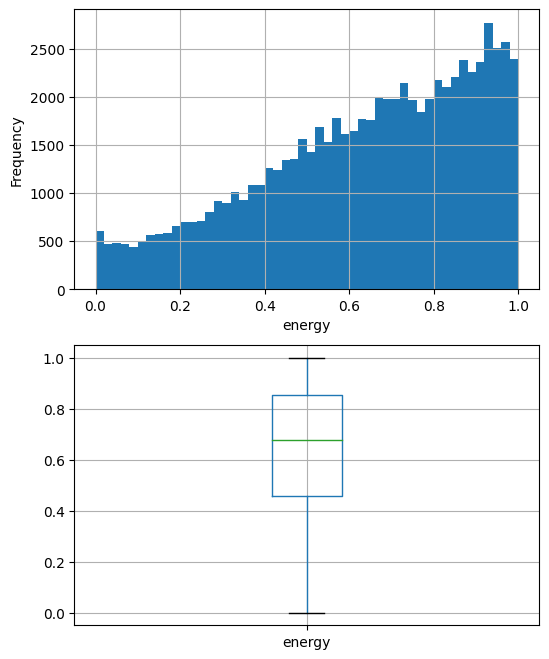

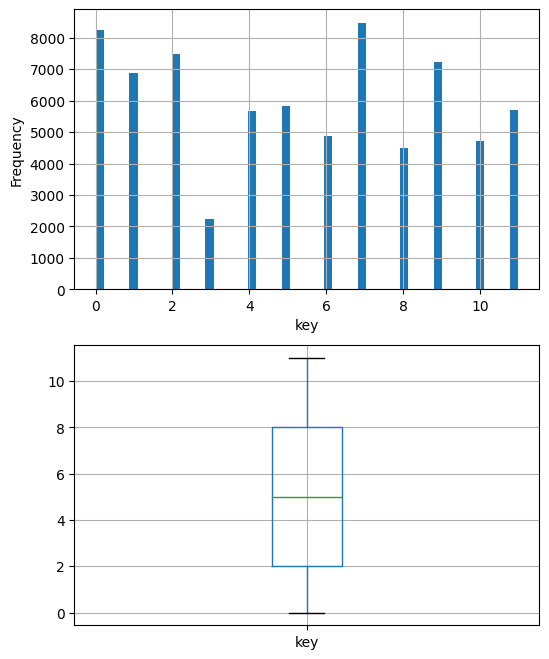

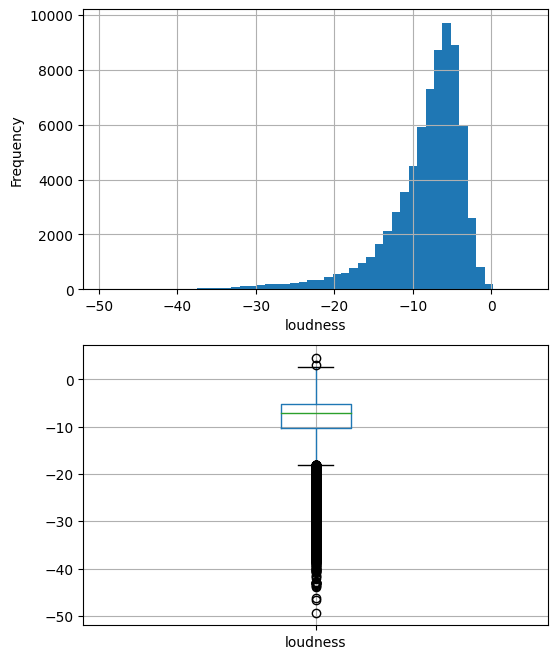

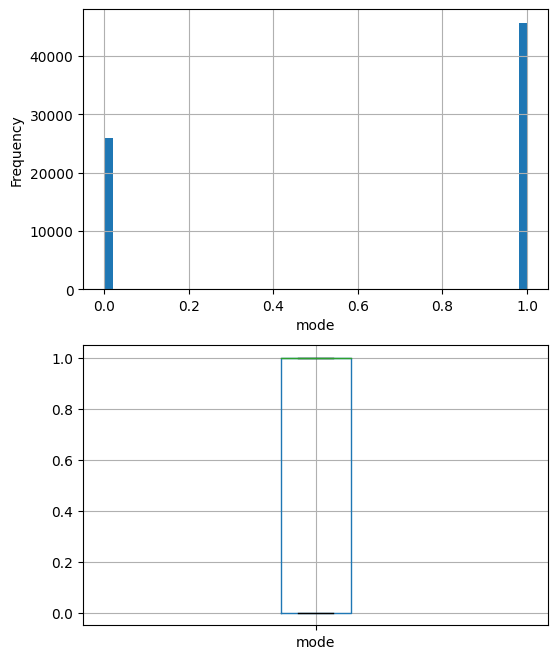

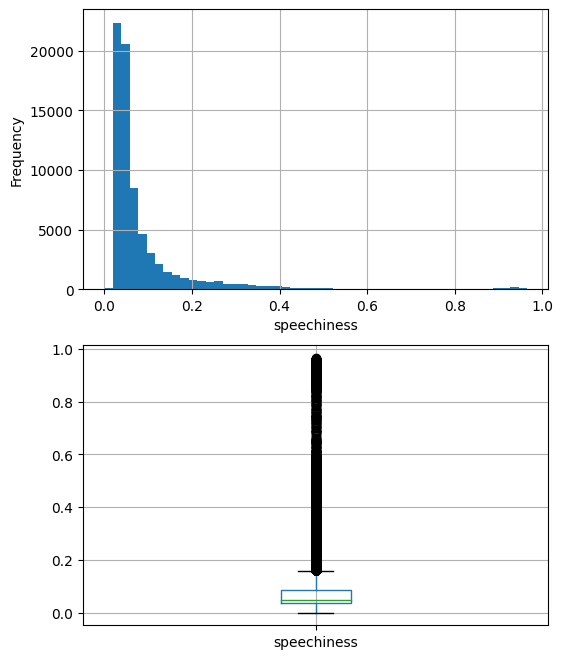

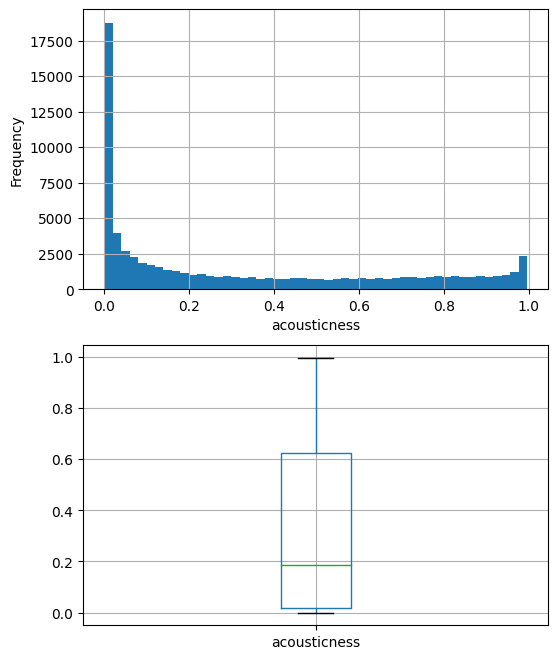

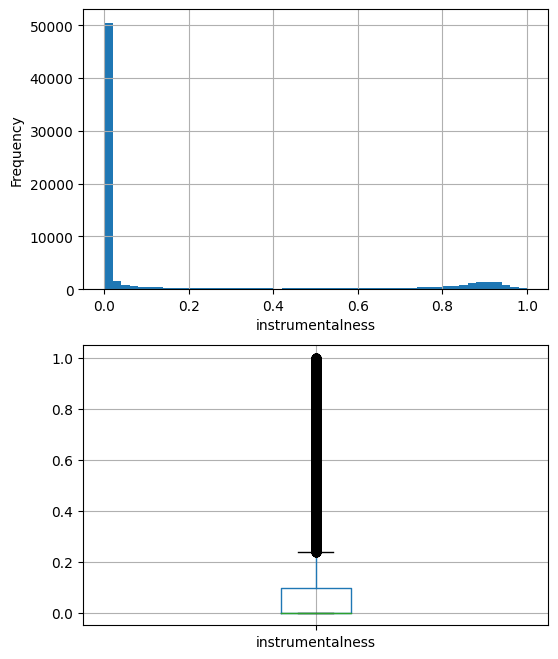

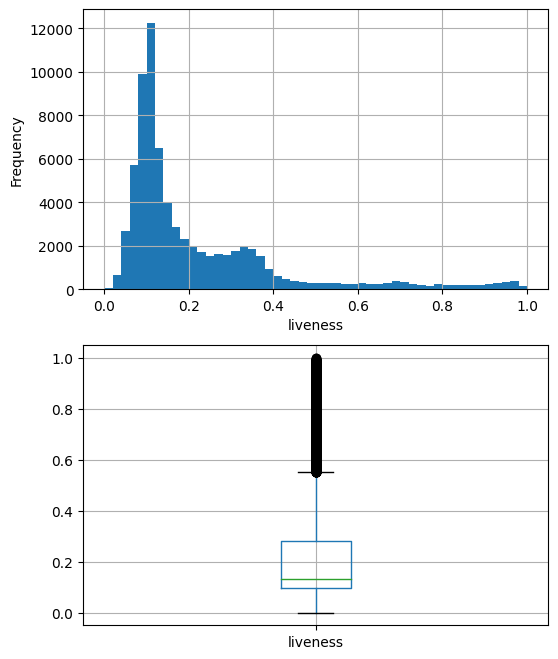

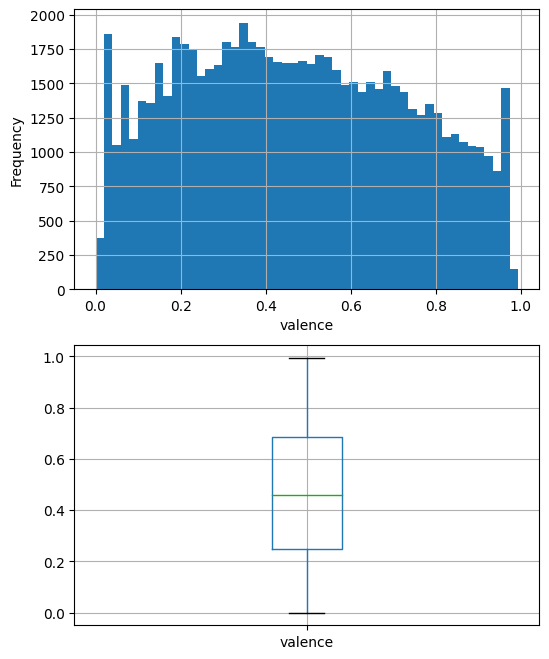

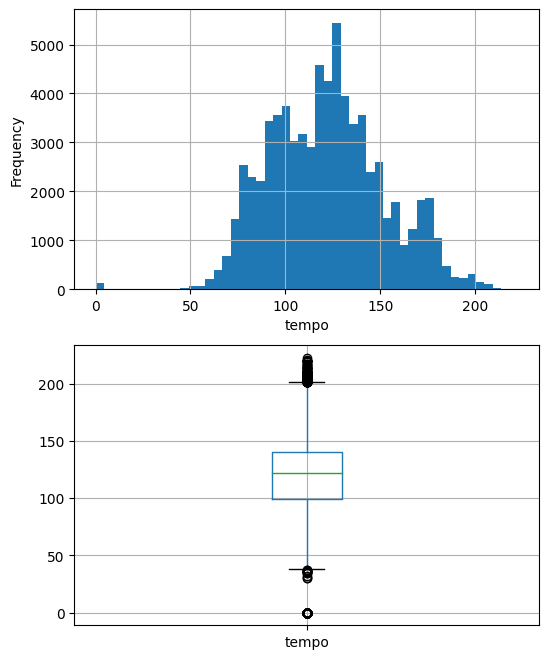

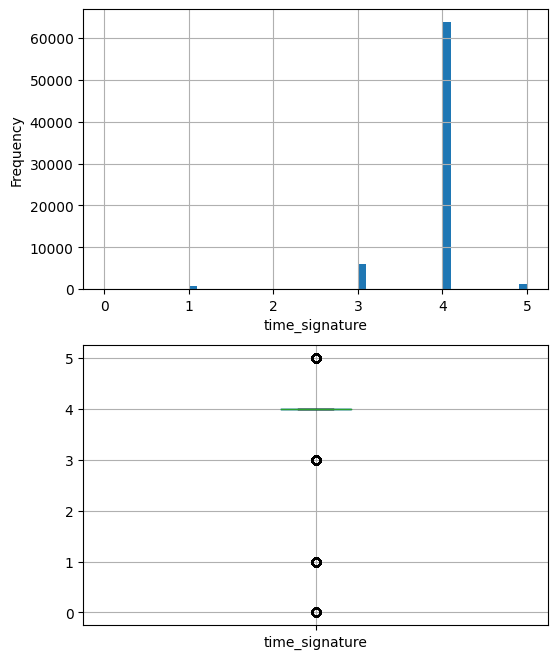

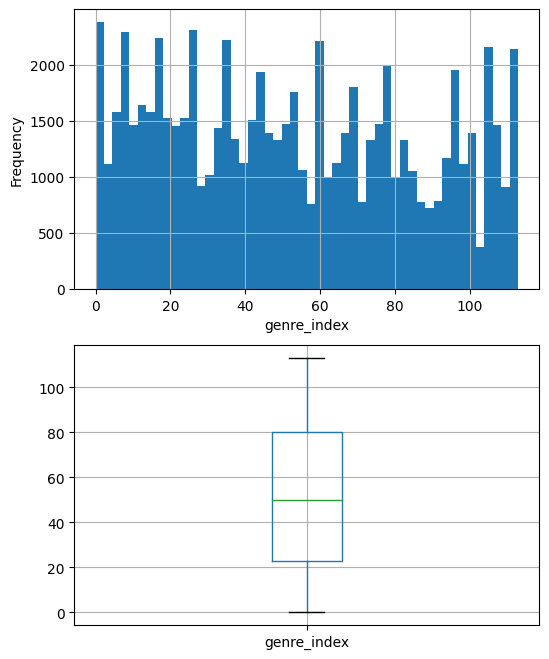

In [55]:
for col in numericCols:
    if df_train[col].dtypes == 'bool':
        continue
    plt.figure(figsize=(6,8))
    plt.subplot(211)
    data = df_train.copy()
    data[col].hist(bins=50)
    plt.xlabel(col)
    plt.ylabel('Frequency')

    plt.subplot(212)
    df_train.boxplot(column=col)
    # plt.title(col)

plt.show()

Observation:

We can see that most of our features have skewed distribution expect 'tempo', 'valence' and 'danceability' which are not entirely symmetrical but only slightly skewed.

Now we plot the count of each value of each discrete column with respect to out target variable genre_index (track_genre) and the median of the genre_index for each value of each feature.

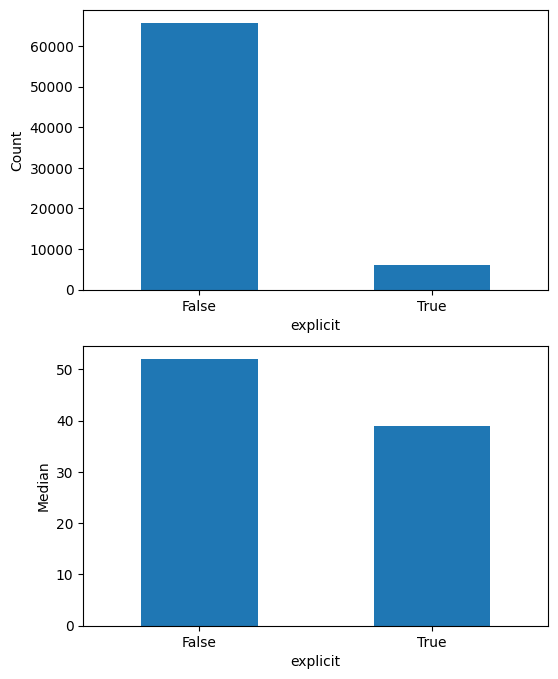

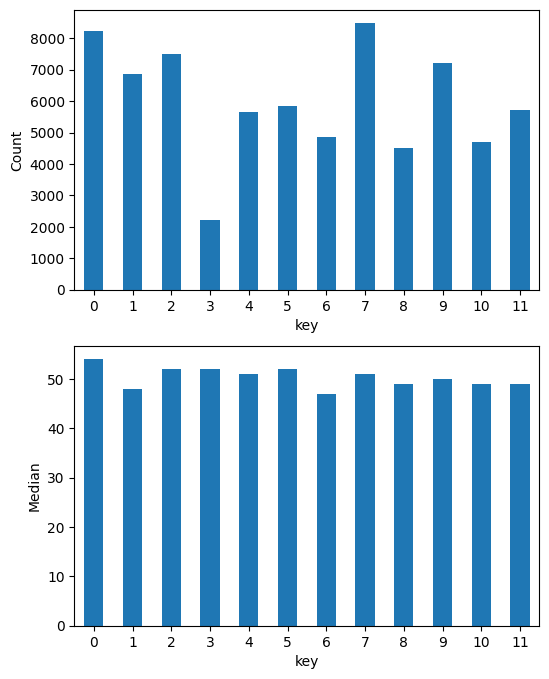

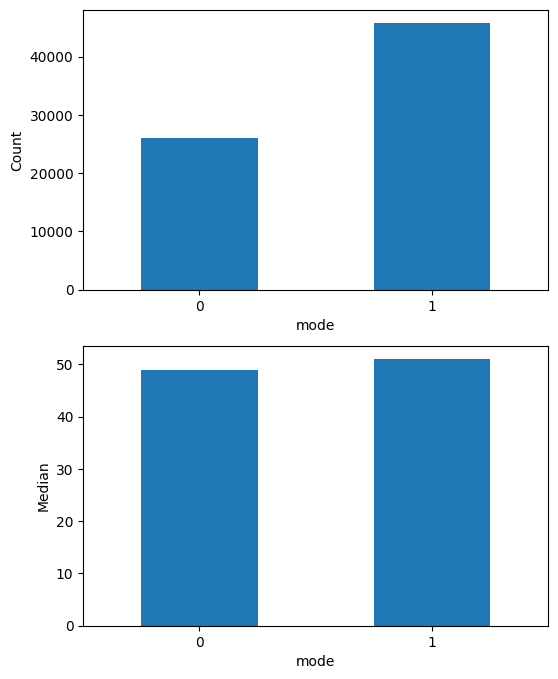

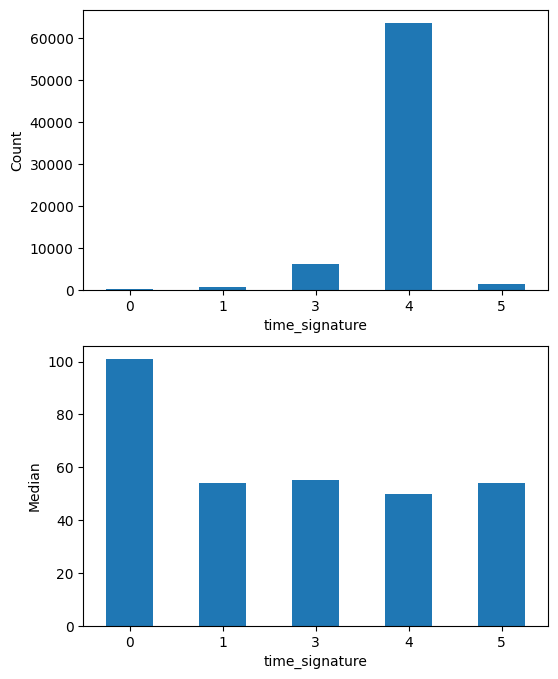

In [56]:
for col in discreteCols:
    plt.figure(figsize=(6,8))
    plt.subplot(2,1,1)
    df_train.groupby(col)['genre_index'].count().plot.bar()
    df_train.reset_index()
    plt.xticks(rotation=0,size=10)
    plt.ylabel('Count')
    plt.subplot(2,1,2)
    df_train.groupby(col)['genre_index'].median().plot.bar()
    df_train.reset_index()
    plt.xticks(rotation=0,size=10)
    plt.ylabel('Median')

plt.show()

Converting the columns of type int64 to float64

In [57]:
for col in df_train.columns:
    if(df_train[col].dtypes in ('int64','bool')) and col != 'genre_index' and col != 'index':
        print(col)
        df_train[col] = df_train[col].astype(float)
print(df_train['genre_index'])

popularity
duration_ms
explicit
key
mode
time_signature
0         67
1        107
2         19
3         74
4        108
        ... 
71787     51
71788     50
71789     21
71790     48
71791     84
Name: genre_index, Length: 71792, dtype: int64


Plotting the heatmap before Scaling

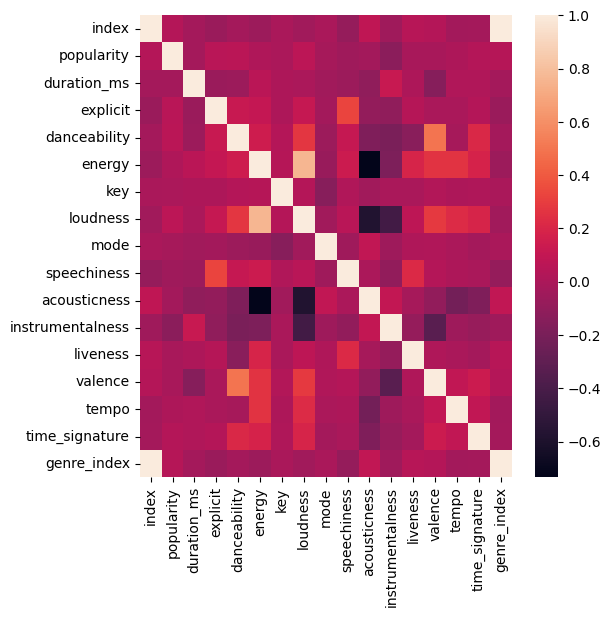

In [58]:
fig,s1 = plt.subplots(figsize=(6,6))
sns.heatmap(df_train[numericCols].corr(),ax = s1)
plt.show()

Scaling the data using MinMaxScalar defined in the file Scaling.py


In [59]:
Scale_obj = MinMaxScaling(df_train)
Scale_obj.Scale()

Now that our data is scaled, we'll plot the heatmap of the scaled data

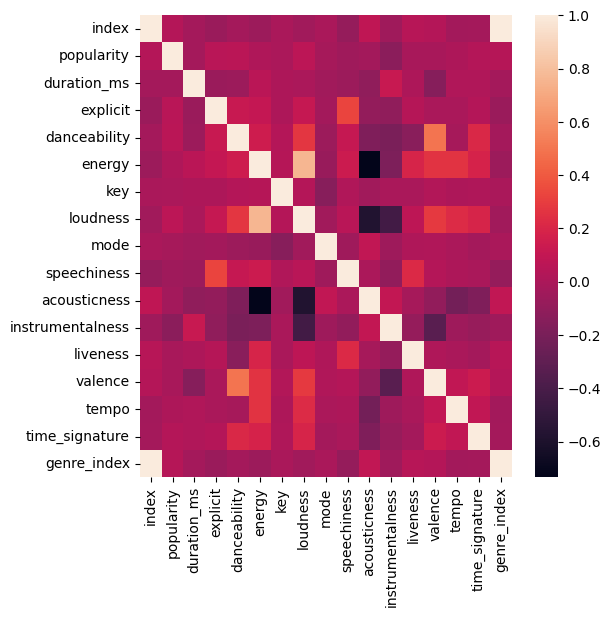

In [60]:
fig,s1 = plt.subplots(figsize=(6,6))
sns.heatmap(df_train[numericCols].corr(),ax = s1)
plt.show()

In [61]:
print(df_train.dtypes)

index                 int64
track_id             object
artists              object
album_name           object
track_name           object
popularity          float64
duration_ms         float64
explicit            float64
danceability        float64
energy              float64
key                 float64
loudness            float64
mode                float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature      float64
track_genre          object
genre_index           int64
dtype: object


Making a training set which contains only the numerical columns

In [62]:
floatCols = [col for col in df_train.columns if df_train[col].dtypes=='float64']
print((floatCols))

X_train = df_train[floatCols]
Y_train = pd.DataFrame(df_train[:]['genre_index'])

['popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']


Loading the Validation set

In [63]:
df_val = pd.read_csv('spotify_val.csv')
Scale_obj = MinMaxScaling(df_val)
Scale_obj.Scale()

Converting all numeric columns to float in the validation set

In [64]:
for col in df_val.columns:
    if(df_val[col].dtypes in ('int64','bool')) and col != 'genre_index' and col != 'index':
        print(col)
        df_val[col] = df_val[col].astype(float)
print(df_val['genre_index'])

Unnamed: 0
popularity
duration_ms
explicit
key
mode
time_signature
0        46
1        59
2        58
3        47
4        38
       ... 
8969     80
8970    110
8971     60
8972     98
8973     87
Name: genre_index, Length: 8974, dtype: int64


In [65]:
X_val = df_val[floatCols]
Y_val = pd.DataFrame(df_val[:]['genre_index'])
print(X_val.dtypes)

popularity          float64
duration_ms         float64
explicit            float64
danceability        float64
energy              float64
key                 float64
loudness            float64
mode                float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature      float64
dtype: object


In [66]:
k=3
knn = KNN(k,3)
knn.fit(X_train,Y_train)
Top10 = knn.HyperParameterTuning(X_val,Y_val)
print(Top10.keys())

71
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
All batches executed successfully
71
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
All batches executed successfully
71
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
All batches executed successfully
dict_keys([(39, 3), (35, 3), (37, 3), (29, 3), (27, 3), (33, 3), (31, 3), (23, 3), (25, 3), (21, 3)])


In [67]:
# print(Top10)

In [68]:
df_test = pd.read_csv('spotify_test.csv')
df_test.rename(columns = {'Unnamed: 0': 'index'},inplace=True)
for col in df_test.columns:
    if(df_test[col].dtypes in ('int64','bool')) and col != 'genre_index' and col != 'index':
        print(col)
        df_test[col] = df_test[col].astype(float)
Scale_obj = MinMaxScaling(df_test)
Scale_obj.Scale()
print(df_test['genre_index'])

popularity
duration_ms
explicit
key
mode
time_signature
0       101
1        21
2        46
3        58
4         0
       ... 
8970      6
8971     64
8972     96
8973      0
8974     16
Name: genre_index, Length: 8975, dtype: int64


In [69]:
X_test = df_test[floatCols]
Y_test = pd.DataFrame(df_test[:]['genre_index'])
print(X_test.dtypes)

popularity          float64
duration_ms         float64
explicit            float64
danceability        float64
energy              float64
key                 float64
loudness            float64
mode                float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature      float64
dtype: object


In [70]:
k = list(Top10.keys())[0][0]
distMet = list(Top10.keys())[0][1]
knn = KNN(k,distMet)
knn.fit(X_train,Y_train)
knn.knn(X_test)
Predicted_Labels = knn.predict()

71
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
All batches executed successfully


In [71]:
Correct = []
for i in range(0,Predicted_Labels.shape[0]):
    if (Predicted_Labels[i] == Y_test.iloc[i]['genre_index']):
        Correct.append(1)
    else:
        Correct.append(0)
accuracy = sum(Correct)/len(Correct)*100
print(accuracy)

25.292479108635096


In [72]:
df2_train = pd.read_csv('/spotify2/train.csv')
df2_val = pd.read_csv('/spotify2/validate.csv')
df2_test = pd.read_csv('/spotify2/test.csv')

In [73]:
df2_train = df2_train.drop_duplicates(subset='track_id', keep='first')
df2_val = df2_val.drop_duplicates(subset='track_id', keep='first')
df2_test = df2_test.drop_duplicates(subset='track_id', keep='first')

In [76]:
# df2_train.drop(columns = 'Unnamed: 0',inplace=True)
df2_val.drop(columns = 'Unnamed: 0',inplace=True)
df2_test.drop(columns = 'Unnamed: 0',inplace=True)
df2_train['genre_index'] = df2_train['track_genre'].map(genreIndex)
df2_val['genre_index'] = df2_val['track_genre'].map(genreIndex)
df2_test['genre_index'] = df2_test['track_genre'].map(genreIndex)

In [77]:
for col in df2_train.columns:
    if(df2_train[col].dtypes in ('int64','bool')) and col != 'genre_index' and col != 'index':
        print(col)
        df2_train[col] = df2_train[col].astype(float)
        df2_val[col] = df2_val[col].astype(float)
        df2_test[col] = df2_test[col].astype(float)

popularity
duration_ms
explicit
key
mode
time_signature


In [78]:
Scale_obj = MinMaxScaling(df2_train)
Scale_obj.Scale()
Scale_obj = MinMaxScaling(df2_val)
Scale_obj.Scale()
Scale_obj = MinMaxScaling(df2_test)
Scale_obj.Scale()

In [79]:
X2_train = df2_train[floatCols]
X2_test = df2_test[floatCols]

Y2_train = pd.DataFrame(df2_train[:]['genre_index'])
Y2_test = pd.DataFrame(df2_test[:]['genre_index'])

# k = list(Top10.keys())[0][0]
# distMet = list(Top10.keys())[0][1]
knn = KNN(k,distMet)
knn.fit(X2_train,Y2_train)
knn.knn(X2_test)
Predicted_Labels = knn.predict()

74
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
All batches executed successfully


In [80]:
Correct = []
for i in range(0,Predicted_Labels.shape[0]):
    if (Predicted_Labels[i] == Y2_test.iloc[i]['genre_index']):
        Correct.append(1)
    else:
        Correct.append(0)
accuracy = sum(Correct)/len(Correct)*100
print(accuracy)

22.5922917230797
